# Objective of this Notebook

The main objective for this notebook is to handle the missing values
of the Age features from the Titanic's disaster dataset (https://www.kaggle.com/c/titanic/data).

When doing data imputation, we can think about using the mean, median
or mode to replace unknown values in dataframes. 
However this basic imputation using those known metrics can introduce bias t

However, we can also use more advanced techniques of imputation 
such as using the prediction values of a model to replace missing values.

We will try to predict the missing values of the 'Age' feature with a linear regression model.

Therefore, we will analyse correlations of other features with
our target 'Age', to select the more useful predictors (or features) 
to predict the missing age values.


## Import data

In [19]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [20]:
def concat_df(train_data, test_data):  
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

train = pd.read_csv("train.csv")
train_shape = train.shape
train.name = 'Training Set'

test = pd.read_csv("test.csv")
test_shape = test.shape
test.name = 'Test Set'

df_all = concat_df(train, test)
df_all.name = 'All Set'


print(df_all.dtypes)


Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
dtype: object


## Features Correlation
### Correlations of other numerical features with the 'Age' feature
#### Pearson correlations on a heatmap


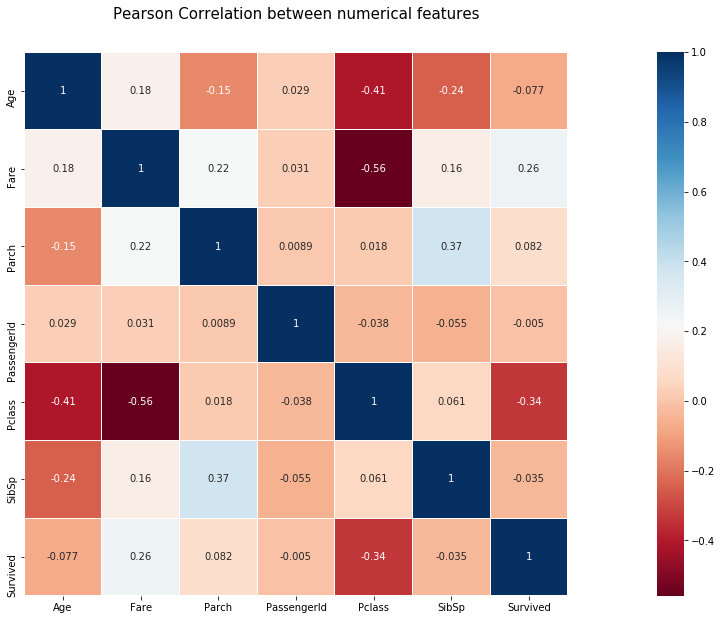

In [21]:
import seaborn as sns

colormap = plt.cm.RdBu
plt.figure(figsize=(32,10))
plt.title('Pearson Correlation between numerical features', y=1.05, size=15)
sns.heatmap(df_all.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

We can see in this heatmap that : 'Fare', 'Parch', 'Pclass' and 'Sibsp' are the most correlated features for the 'Age' feature.

### Between 1 numerical feature (Age) and other categorical features

#### ANOVA 
To see if there is a correlation between 'Sex' (nominal feature) and 'Age' (numerical feature)
we can do a statistical test called ANOVA (Analysis of variance) between those 2 features.

Analysis of variance is used to study the behavior of a quantitative/continue variable (target : Age) to be explained as a function of one or more categorical nominal variables.

We can use one-way anova when we have one nominal variable and one measurement variable; the nominal variable divides the measurements into two or more groups. It tests whether the means of the measurement variable are the same for the different groups.


In [22]:
print('Feature \'Sex\' have ', len(set(df_all['Sex'].values)), ' distinct values.',set(df_all['Sex'].values))

Feature 'Sex' have  2  distinct values. {'female', 'male'}


Here the feature 'Sex' has 2 possible values 'male' and 'female', we have 2 groups.

We will now import the library statsmodels and get the results obtained from the one-way anova

In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#We only want Sex and Age columns
age_and_sex = df_all[['Sex','Age']]


lm = ols('Age ~ Sex', data = age_and_sex).fit()
table = sm.stats.anova_lm(lm)
print(table)

              df         sum_sq     mean_sq         F    PR(>F)
Sex          1.0     879.392121  879.392121  4.246108  0.039588
Residual  1044.0  216218.089825  207.105450       NaN       NaN


When doing ANOVA, we have 2 hypotheses:
* The null hypothesis H0 saying that : the mean of those differents distributions (for male and female) are equal to the global mean regarding the entire distribution (male and female). Thus there is no correlation between sex and age. 
* The alternative hypothesis Ha saying that there is at least one mean which is different from other means. In this case, it's possible to have a correlation between 'Sex' and 'Age'.

When doing ANOVA, if we have a p-value lower than the threshold alpha = 0.05, we can reject the null hypothesis.
We can see in this table taht the p-value 'PR(>F)' is equal to 0.039588 and thus lower than 0.05 .

**Thus there is a statistically significant difference between age means between the male and female distributions.**
This means that with the observed data, there is enough evidence to assume a general difference in age regarding males and females.

**Thus, We can select the 'Sex' feature as a predictor to predict age missing values.**

We now have several features to predict and impute age missing values :
* Fare, 
* Parch, 
* Pclass,
* Sibsp,
* Sex


## Convert categorical variable 'Sex' into dummy/indicator variables
Sex is a nominal value, we need to encode it (one hot encoding) before we pass this feature to the regression model which supports only numerical values for features.

In [24]:
dummies = pd.get_dummies(df_all['Sex'], prefix='Sex')
df_all = pd.concat([df_all,dummies],axis=1)
print(df_all.columns)

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Sex_female',
       'Sex_male'],
      dtype='object')


## Prepare training and test sets

In [25]:

predictors_df = df_all[["Fare","Parch","Pclass","SibSp","Sex_female","Sex_male","Age"]]

    
#Lines where Age is known
training_set = predictors_df[pd.isnull(predictors_df[['Age']]).any(axis=1)==False]
#There is one 'Fare' missing, let's delete the line conaining the NaN value
training_set = training_set.dropna()
X_train = training_set.drop(columns = 'Age')
y_train =  training_set[['Age']] 

#Lines where Age is unknown (NaN)
test_set = predictors_df[pd.isnull(predictors_df[['Age']]).any(axis=1)]
X_test = test_set.drop(columns = 'Age') 
y_test =  test_set[['Age']]

## Train & predict age missing values

In [26]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)
predicted = model.predict(X_test)

#Predicted values of age are floats, ages need to be integers
predicted = [ int(i) for i in predicted]

## Replace NaN ages values by their predictions in the dataframe

In [27]:
import math

age_to_impute_index = 0
age_column_values=[]

for age in df_all['Age'] :
    if (math.isnan(age)):
        age_column_values.append(predicted[age_to_impute_index])
        age_to_impute_index += 1
    else : age_column_values.append(age)

print("Columns with missing values in the dataframe (Before replacement):",df_all.columns[df_all.isnull().any()])

#We replace the Age with Unknown values with a new column containing our predictions.
df_all.loc[:, "Age"] = age_column_values

print("Columns with missing values in the dataframe (After replacement):",df_all.columns[df_all.isnull().any()])


Columns with missing values in the dataframe (Before replacement): Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Survived'], dtype='object')
Columns with missing values in the dataframe (After replacement): Index(['Cabin', 'Embarked', 'Fare', 'Survived'], dtype='object')


**All the missing values of 'Age' have been predicted !**

# Conclusion

Mean/Median/Mode imputations are known to be simple and fast but they indroduce bias in our dataset.
This type of imputation also reduces the variance of the data and does not take into account correlations between variables which can be used to have more accurate imputations.

That's why we used Linear regression imputation which takes into account correlations with our target, here the 'Age' feature.
We have seen another technique to impute missing values. However using a linear regression model could have some drawbacks:

* If there is no linear relationship between the variables used in the training process, the prediction of the missing value may be inaccurate.
* Linear regression also suffers from Multicollinearity which happens when one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy. This can lead to skewed or misleading results.
* as in a mean substitution, while a regression imputation substitutes a value that is predicted from other variables, no novel information is added, while the sample size has been increased and the standard error is reduced.

Fortunately, there is a lot of brilliant alternatives to mean/median/mode and linear regression imputations:
* Multivariate imputation by chained equations (MICE) has emerged as a principled method of dealing with missing data. (more info here : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)
* KNN : This popular imputation technique is based on the K-Nearest Neighbours algorithm. For a given instance with missing data, KNN Impute returns n most similar neighbours and replaces the missing element with a mean or mode of the neighbours.